# BAKU - Prediction Test for archs comparision
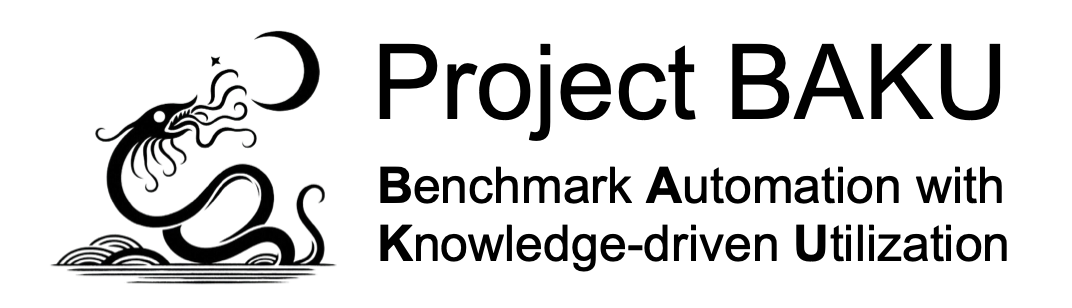


### Imports and Configs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys  
import json
import ast
sys.path.insert(1, '../scripts/benchGen_Dataset/')
import geminiAsker as ga
#import gptAsker as gpt
sys.path.insert(2, '../scripts/classes/')
from data_loader import DataLoader

### Setup

In [ ]:
def extract_perf_vector(perf_string: str) -> list[float]:

    lines = perf_string.strip().split('\n')
    
    for line in lines:
        if ',' in line and any(char.isdigit() for char in line):
            value_strings = line.split(',')
            
            try:
                perf_vector = [float(val) for val in value_strings]
                return perf_vector
            except ValueError:
                continue
                
    raise Exception("No Vector predicted.")

In [ ]:
def in_confidence_interval(attr: str, value: float, series) -> bool:
    """
    Checks if a value falls within the confidence interval stored in a pandas Series/DataFrame row.
    """
    low_col = attr + "_ic_low"
    high_col = attr + "_ic_high"
    low_bound = float(series[low_col].iloc[0])
    high_bound = float(series[high_col].iloc[0])

    return low_bound <= value <= high_bound

In [ ]:
def prediction_gen_stats(data,models,df_guima,df_natan,api_asker):
    generate_data = DataLoader("../data/prediction_test/results.csv")
    for model in models:
        for dic in data:
            try:
                output = api_asker(prompt=dic["instruction"],model_name=model)
                perf_pred = extract_perf_vector(output)
                
                s_guima = df_guima[df_guima["Program"] == dic["program"]]
                s_natan = df_natan[df_natan["Program"] == dic["program"]]
            
                if s_natan.empty and dic["destination"] == "natan": 
                    continue
                elif not s_natan.empty and dic["destination"] == "natan":
                    result_cpu = in_confidence_interval(attr="cpu-cycles",value=perf_pred[0],series=s_natan)
                    result_instructions = in_confidence_interval(attr="instructions",value=perf_pred[1],series=s_natan)
                    result_cache_ref = in_confidence_interval(attr="cache-references",value=perf_pred[2],series=s_natan)
                    result_cache_misses = in_confidence_interval(attr="cache-misses",value=perf_pred[3],series=s_natan)
                    generate_data.new_row([dic["program"],model,perf_pred[0],perf_pred[1],perf_pred[2],perf_pred[3],"guima","natan",result_cpu,result_instructions,result_cache_ref,result_cache_misses])
            
                if s_guima.empty and dic["destination"] == "guima": 
                    continue
                elif not s_guima.empty and dic["destination"] == "guima":
                    result_cpu = in_confidence_interval(attr="cpu-cycles",value=perf_pred[0],series=s_guima)
                    result_instructions = in_confidence_interval(attr="instructions",value=perf_pred[1],series=s_guima)
                    result_cache_ref = in_confidence_interval(attr="cache-references",value=perf_pred[2],series=s_guima)
                    result_cache_misses = in_confidence_interval(attr="cache-misses",value=perf_pred[3],series=s_guima)
                    generate_data.new_row([dic["program"],model,perf_pred[0],perf_pred[1],perf_pred[2],perf_pred[3],"natan","guima",result_cpu,result_instructions,result_cache_ref,result_cache_misses])
                
                generate_data.save()
            
            except Exception as e:
                print(f"Error:{e}")    
    
    

In [ ]:
def prediction_gen_qualitative(data,models,df_guima,df_natan,api_asker):
    generated_data = []
    for model in models:
        for dic in data:
            try:
                output = api_asker(prompt=dic["instruction"],model_name=model)
                generated_data.append({"output":output, "program" : dic["program"], "origin":dic["origin"], "destination": dic["destination"]})
            except Exception as e:
                print(f"Error:{e}")
    
    with open("../data/prediction_test/output_qualitative.jsonl", "w", encoding="utf-8") as jsonl_file:
        for entry in generated_data:
            jsonl_file.write(json.dumps(entry) + "\n")    

In [ ]:
def plot_histogram(df, attr,figname,operation):
    plt.figure(figsize=(10, 6))
    plt.hist(df[attr], bins=30, edgecolor='black', alpha=0.7)
    plt.title(operation)
    plt.xlabel(f'Diferença em {attr} - {operation}')
    plt.ylabel('Frequência')
    plt.grid(True)
    output_plot_path = f"assets/{attr}_{figname}_{operation}_distribution.clearpng"
    plt.savefig(output_plot_path)
    plt.show()
    plt.close()

In [ ]:
def mean_distribution(df_a, df_b, counter,operation):
    counter_mean = counter + "_mean"

    if counter_mean not in df_a.columns or counter_mean not in df_b.columns:
        print(f"Erro: '{counter_mean}' was not found.")
        return

    df_a_means = df_a[counter_mean]
    df_b_means = df_b[counter_mean]
    

    print(counter)
    means = []
    for _ in range(100000):
        temp_a = df_a_means.sample(n=4, replace=True)
        temp_b = df_b_means.sample(n=4, replace=True)
        means.append(np.mean(temp_a) - np.mean(temp_b))

    df_means = pd.DataFrame({counter_mean: means})

    output_csv_path = f"../data/prediction_test/distributions/{counter_mean}{operation}_distribution.csv"
    df_means.to_csv(output_csv_path, index=False)

    plot_histogram(df_means,counter_mean,counter,operation)

In [ ]:
def question_dist(list,operation):
    series = pd.Series(list)

    series = series.value_counts()

    plt.figure(figsize=(10, 7))
    series.plot(kind='bar', color='lightcoral')

    plt.title(f"Frequência das Respostas de {operation}", fontsize=16)
    plt.ylabel("Quantidade de Ocorrências", fontsize=12)
    plt.xlabel("Respostas", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.savefig(f'assets/grafico_respostas_{operation}.png')

### Prediction

In [ ]:
df_guima = pd.read_csv("../data/prediction_test/perf_data_server_guima.csv")
df_natan = pd.read_csv("../data/prediction_test/perf_data_server_natan.csv")

In [ ]:
attrs = ["cpu-cycles","instructions","cache-references","cache-misses"]

for attr in attrs:
    mean_distribution(df_guima,df_natan,attr,"A_B")
    mean_distribution(df_guima,df_guima,attr, "A")
    mean_distribution(df_natan,df_natan,attr, "B")

In [ ]:
input_data = []
gemini_models = ["gemini-2.5-flash","gemini-2.5-pro"]
gpt_models = ["gpt-3.5-turbo-0125"]

with open('../data/prediction_test/test.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        line_dict = ast.literal_eval(line)
        input_data.append(line_dict)


In [ ]:
prediction_gen_stats(input_data,gemini_models,df_guima,df_natan,ga.geminiAsker)  

In [ ]:
prediction_gen_qualitative(input_data,gemini_models,df_guima,df_natan,ga.openaiAsker)

In [ ]:
df = pd.read_csv('../data/prediction_test/results.csv')

models = df['model'].unique()

for model in models:
    
    model_df = df[df['model'] == model]
    
    for col in ['cpu_bool', 'instructions_bool', 'cache_ref_bool', 'cache_misses_bool']:
        counts = model_df[col].value_counts()
        
        print(counts)
        
        plt.figure(figsize=(8, 6))
        
        ax = counts.plot(kind='bar', color=['skyblue', 'salmon'])
        
        plt.title(f'Comparação de Acertos e Erros para {col}\nModelo: {model}')
        
        plt.xlabel('Resultado')
        plt.ylabel('Contagem')
        
        plt.xticks(rotation=0)
        
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
        plt.tight_layout()
        
        plt.savefig(f'{model}_{col}_comparison.png')
        plt.show()
        plt.close()
        
    print("\n\n")

### Graphs

In [ ]:
qualitative_answers_natan = []
qualitative_answers_guima = []

for question in input_data:
    if question["type"] == "random_qualitative" and question["origin"]=="guima":
        qualitative_answers_guima.append(question["answer"])
        
    elif question["type"] == "random_qualitative" and question["origin"]=="natan":
        qualitative_answers_natan.append(question["answer"])

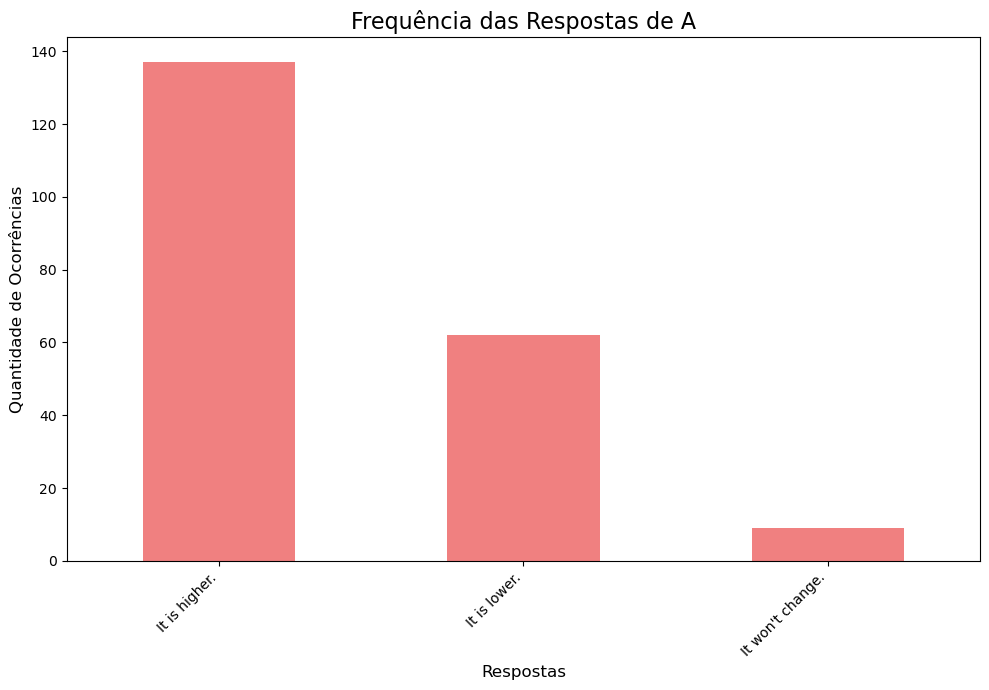

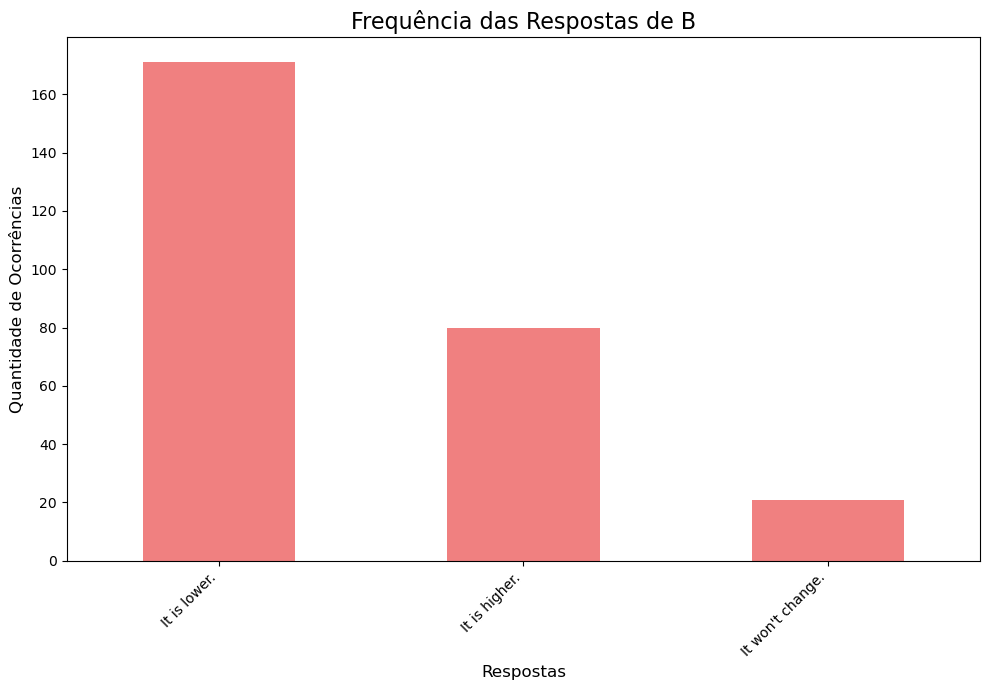

In [27]:
question_dist(qualitative_answers_guima,"A")
question_dist(qualitative_answers_natan,"B")